In [1]:
#Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation
import matplotlib.patches as mpatches

In [2]:
# Get the current working directory
cwd = os.path.normpath(os.path.dirname(os.getcwd()))

def load_csv(file_path):
    """
    Function to load a CSV file into a pandas DataFrame.
    """
    full_path = os.path.join(cwd, file_path)
    return pd.read_csv(full_path, index_col=0)


In [3]:
# Define file paths for each CSV file

file_paths = {
    'FL_Grossload': [
        'Federatedlearning/results/Results_DS_FL_Grossload_Forecasting.csv',
    ],
    'LL_Grossload': [
        'Locallearning/results/Results_DS_LL_Grossload_Forecasting.csv',
    ],
    'FL_Prosumption': [
        'Federatedlearning/results/Results_DS_FL_Prosumption_Forecasting.csv',
    ],
    'LL_Prosumption': [
        'Locallearning/results/Results_DS_LL_Prosumption_Forecasting.csv',
    ],
    'FL_PV': [
        'Federatedlearning/results/Results_DS_FL_PV_Forecasting.csv',
    ],
    'LL_PV': [
        'Locallearning/results/Results_DS_LL_PV_Forecasting.csv',
    ],
    'FL_Totalload': [
        'Federatedlearning/results/Results_DS_FL_Totalload_Forecasting.csv',
    ],
    'LL_Totalload': [
        'Locallearning/results/Results_DS_LL_Totalload_Forecasting.csv',
    ]
}


# Dataframe

In [4]:
def process_dataframe(df, scenario):
    """
    Function to process a DataFrame, extract model names from metric column names, and return aggregated boxplot statistics for RMSE.
    """
    # Define the model name mapping
    model_name_mapping = {
        'BiLSTM': 'Lstm',
        'CNN': 'Cnn',
        'Transformer': 'Transformer',
        'soft_bilstm': 'Soft_Lstm',
        'topk_bilstm': 'Topk_Lstm',
        'soft_dense': 'Soft_Dense',
        'topk_dense': 'Topk_Dense'
    }

    # Initialize an empty DataFrame to store results
    all_stats = pd.DataFrame()
    rmse_columns = [col for col in df.columns if 'RMSE' in col] 
    
    for rmse_col in rmse_columns:
        # Extract the model name from the column name
        model_key = rmse_col.split('_')[1:]
        model_key = "_".join(model_key)
        standardized_model = model_name_mapping.get(model_key, 'Unknown')

        # Calculate mean and standard deviation of RMSE for the current model
        mean_rmse = df[rmse_col].mean()
        std_rmse = df[rmse_col].std()

        # Create a DataFrame to store the statistics for this model
        stats = pd.DataFrame({
            'model': standardized_model,
            'mean': mean_rmse,
            'std': std_rmse,
            'model_type': scenario
        }, index=[0])


        # Append to the all_stats DataFrame
        all_stats = pd.concat([all_stats, stats], ignore_index=True)

    # Split the model_type into 'learning' and 'data' columns
    all_stats[['learning', 'data']] = all_stats['model_type'].str.split('_', expand=True)
    all_stats.drop(columns=['model_type'], inplace=True)
    return all_stats

# Load and process all DataFrames
all_results = []
for category, paths in file_paths.items():
    for path in paths:
        df = load_csv(path)
        processed_df = process_dataframe(df, scenario=category)
        all_results.append(processed_df)

# Concatenate all results into one DataFrame
combined_average_metrics = pd.concat(all_results, ignore_index=True)

In [5]:
#combined_average_metrics[(combined_average_metrics['model'] == 'Lstm')]

In [5]:
# Create an empty DataFrame for data_stream_df
data_stream_df = pd.DataFrame()

# Filter the DataFrame for 'Grossload' data
data_columns = ['Grossload', 'Totalload'] #'PV', 'Prosumption'
for data in data_columns:
    filtered_results = combined_average_metrics[(combined_average_metrics['data'] == data)]

    # Create a custom order for the models
    custom_order = ['Lstm', 'Cnn', 'Transformer', 'Soft_Dense', 'Topk_Dense', 'Soft_Lstm', 'Topk_Lstm']

    # Pivot the DataFrame to reshape it
    reshaped_results = filtered_results.pivot(index='model', columns='learning', values=['mean', 'std'])

    # Rename the columns for clarity
    reshaped_results.columns = [f'{col[0]}_{col[1]}_{data}' for col in reshaped_results.columns]

    # Reorder the rows based on the custom order
    reshaped_results = reshaped_results.loc[custom_order]

    # Reorder the columns
    reshaped_results = reshaped_results[[f'mean_LL_{data}', f'std_LL_{data}']]
    reshaped_results = reshaped_results.round(4)

    # Concatenate reshaped_results to data_stream_df
    data_stream_df = pd.concat([data_stream_df, reshaped_results], axis=1)

data_stream_df

,mean_LL_Grossload,std_LL_Grossload,mean_LL_Totalload,std_LL_Totalload
model,,,,
Lstm,0.0842,0.0153,0.0969,0.0200
Cnn,0.1036,0.0208,0.1194,0.0250
Transformer,0.1028,0.0240,0.1217,0.0323
Soft_Dense,0.0791,0.0136,0.0916,0.0190
Topk_Dense,0.0799,0.0142,0.0930,0.0194
Soft_Lstm,0.0781,0.0142,0.0912,0.0199
Topk_Lstm,0.0802,0.0141,0.0930,0.0202


In [6]:
data_stream_df = pd.DataFrame()

# Filter the DataFrame for 'Grossload' data
data_columns = ['PV', 'Prosumption'] #
for data in data_columns:
    filtered_results = combined_average_metrics[(combined_average_metrics['data'] == data)]

    # Create a custom order for the models
    custom_order = ['Lstm', 'Cnn', 'Transformer', 'Soft_Dense', 'Topk_Dense', 'Soft_Lstm', 'Topk_Lstm']

    # Pivot the DataFrame to reshape it
    reshaped_results = filtered_results.pivot(index='model', columns='learning', values=['mean', 'std'])

    # Rename the columns for clarity
    reshaped_results.columns = [f'{col[0]}_{col[1]}_{data}' for col in reshaped_results.columns]

    # Reorder the rows based on the custom order
    reshaped_results = reshaped_results.loc[custom_order]

    # Reorder the columns
    reshaped_results = reshaped_results[[f'mean_LL_{data}', f'std_LL_{data}']]
    reshaped_results = reshaped_results.round(4)

    # Concatenate reshaped_results to data_stream_df
    data_stream_df = pd.concat([data_stream_df, reshaped_results], axis=1)

data_stream_df

,mean_LL_PV,std_LL_PV,mean_LL_Prosumption,std_LL_Prosumption
model,,,,
Lstm,0.0944,0.0131,0.0898,0.0189
Cnn,0.2563,0.0202,0.1205,0.0225
Transformer,0.1971,0.0582,0.1253,0.0343
Soft_Dense,0.0921,0.0104,0.0845,0.0171
Topk_Dense,0.0926,0.0104,0.0858,0.0174
Soft_Lstm,0.0910,0.0097,0.0832,0.0181
Topk_Lstm,0.0900,0.0099,0.0853,0.0167


# Boxplots

In [7]:
def process_dataframe(df, scenario):
    """
    Function to process a DataFrame, extract model names from metric column names, and return aggregated boxplot statistics for RMSE.
    """
    # Define the model name mapping
    model_name_mapping = {
        'BiLSTM': 'Lstm',
        'CNN': 'Cnn',
        'Transformer': 'Transformer',
        'soft_bilstm': 'Soft_Lstm',
        'topk_bilstm': 'Topk_Lstm',
        'soft_dense': 'Soft_Dense',
        'topk_dense': 'Topk_Dense'
    }

    # Initialize an empty DataFrame to store results
    all_stats = pd.DataFrame()
    rmse_columns = [col for col in df.columns if 'RMSE' in col] 
    for rmse_col in rmse_columns:
        # Calculate boxplot statistics for RMSE of the current model
        if rmse_col in df.columns:
            stats = df[rmse_col].describe(percentiles=[.25, .5, .75])
            stats = stats[['min', '25%', '50%', '75%', 'max']].to_frame().T
            
            model_key = rmse_col.split('_')[1:]
            model_key = "_".join(model_key)
            standardized_model = model_name_mapping.get(model_key)
            stats['model'] = standardized_model

            stats['model_type'] = scenario

            # Append to the all_stats DataFrame
            all_stats = pd.concat([all_stats, stats], ignore_index=True)

    # Split the model_type into 'learning' and 'data' columns
    all_stats[['learning', 'data']] = all_stats['model_type'].str.split('_', expand=True)
    all_stats.drop(columns=['model_type'], inplace=True)

    return all_stats

# Load and process all DataFrames
all_results = []
for category, paths in file_paths.items():
    for path in paths:
        df = load_csv(path)
        processed_df = process_dataframe(df, scenario=category)
        all_results.append(processed_df)

# Concatenate all results into one DataFrame
combined_average_metrics = pd.concat(all_results, ignore_index=True)

In [8]:
combined_average_metrics[(combined_average_metrics['data'] == 'Grossload') & (combined_average_metrics['learning'] == 'FL')]

,min,25%,50%,75%,max,model,learning,data
0,0.056678,0.114413,0.151004,0.177406,0.225335,Lstm,FL,Grossload
1,0.062213,0.143648,0.178604,0.211991,0.304772,Cnn,FL,Grossload
2,0.060224,0.141666,0.171538,0.201268,0.293617,Transformer,FL,Grossload
3,0.051750,0.112109,0.156554,0.177143,0.230108,Soft_Dense,FL,Grossload
4,0.051366,0.106464,0.143734,0.170330,0.205960,Soft_Lstm,FL,Grossload
5,0.052240,0.119760,0.155965,0.183061,0.237043,Topk_Dense,FL,Grossload
6,0.053223,0.113274,0.154125,0.178955,0.217437,Topk_Lstm,FL,Grossload


In [19]:
#model_type = FL_Grossload, LL_Grossload, FL_Prosumption, LL_Prosumption, FL_PV, LL_PV, FL_Totalload, LL_Totalload
df_grossload = combined_average_metrics[combined_average_metrics['data'].str.contains("Grossload")]
df_prosumption = combined_average_metrics[combined_average_metrics['data'].str.contains("Prosumption")]
df_pv = combined_average_metrics[combined_average_metrics['data'].str.contains("PV")]
df_totalload = combined_average_metrics[combined_average_metrics['data'].str.contains("Totalload")]

In [18]:
def get_plot_title_new(use_case):
    """
    Returns a descriptive title based on the use case.
    """
    return f'RMSE for {use_case} Forecasting'

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

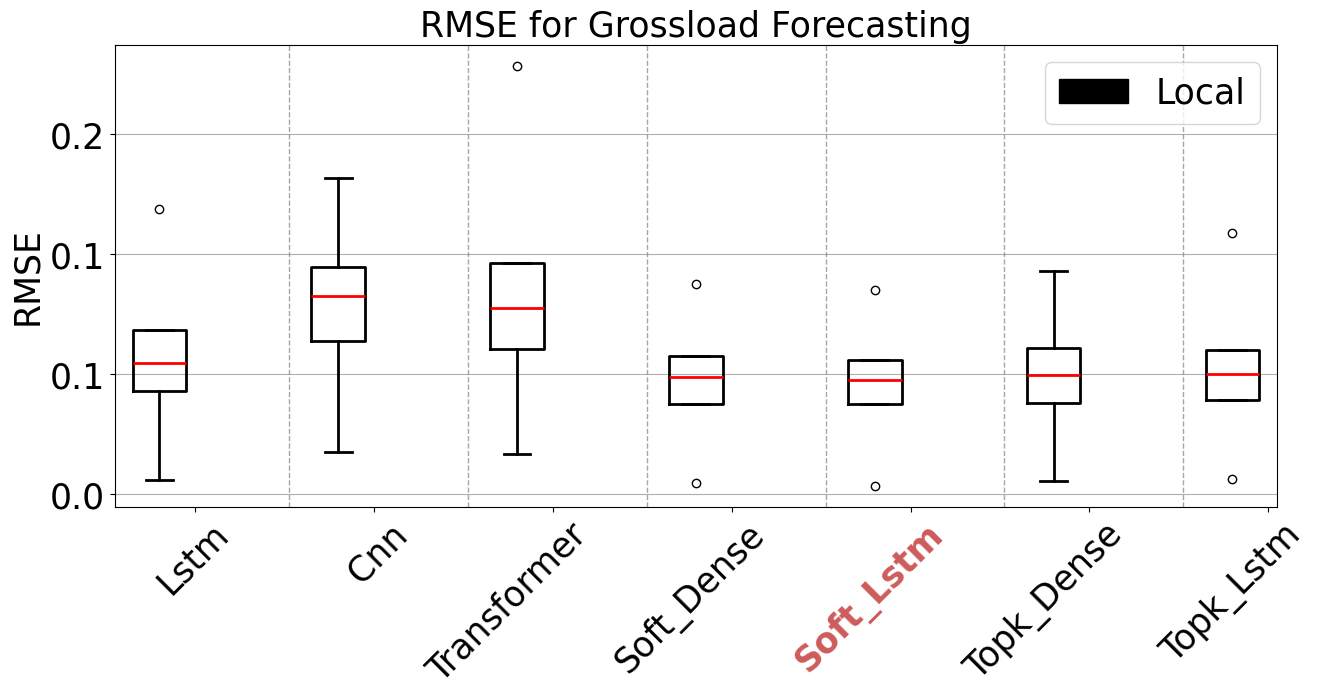

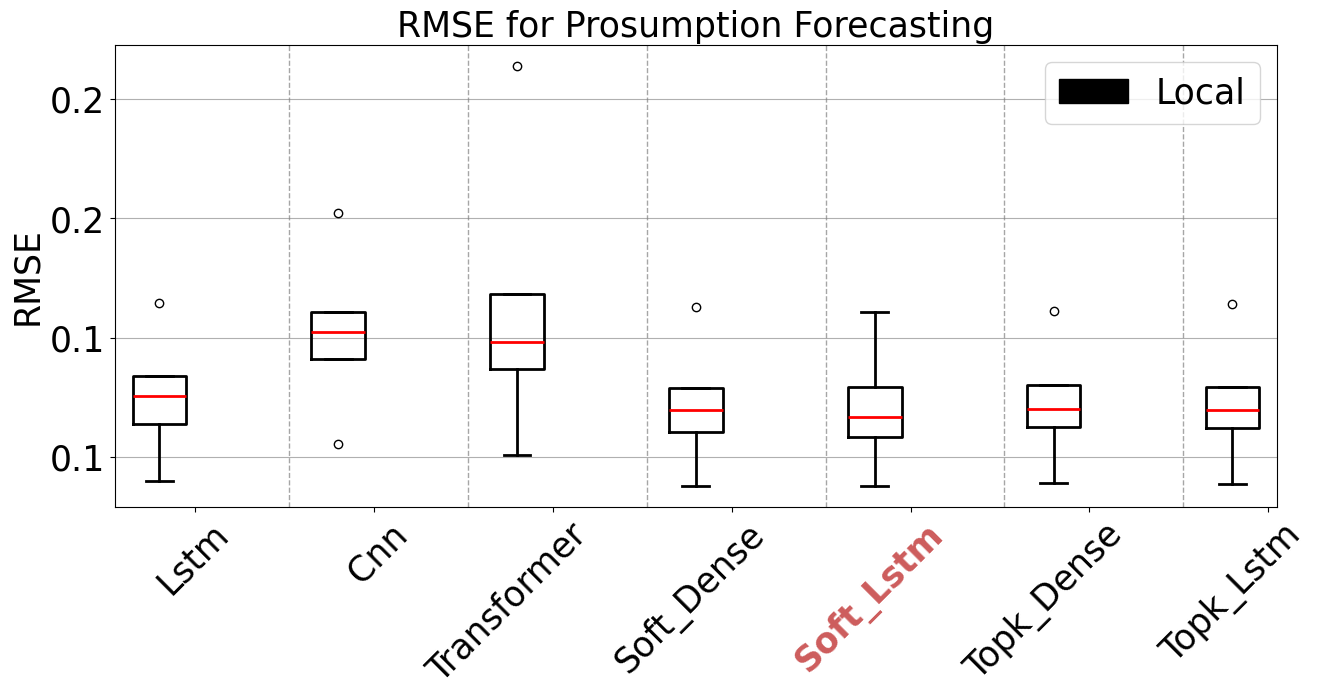

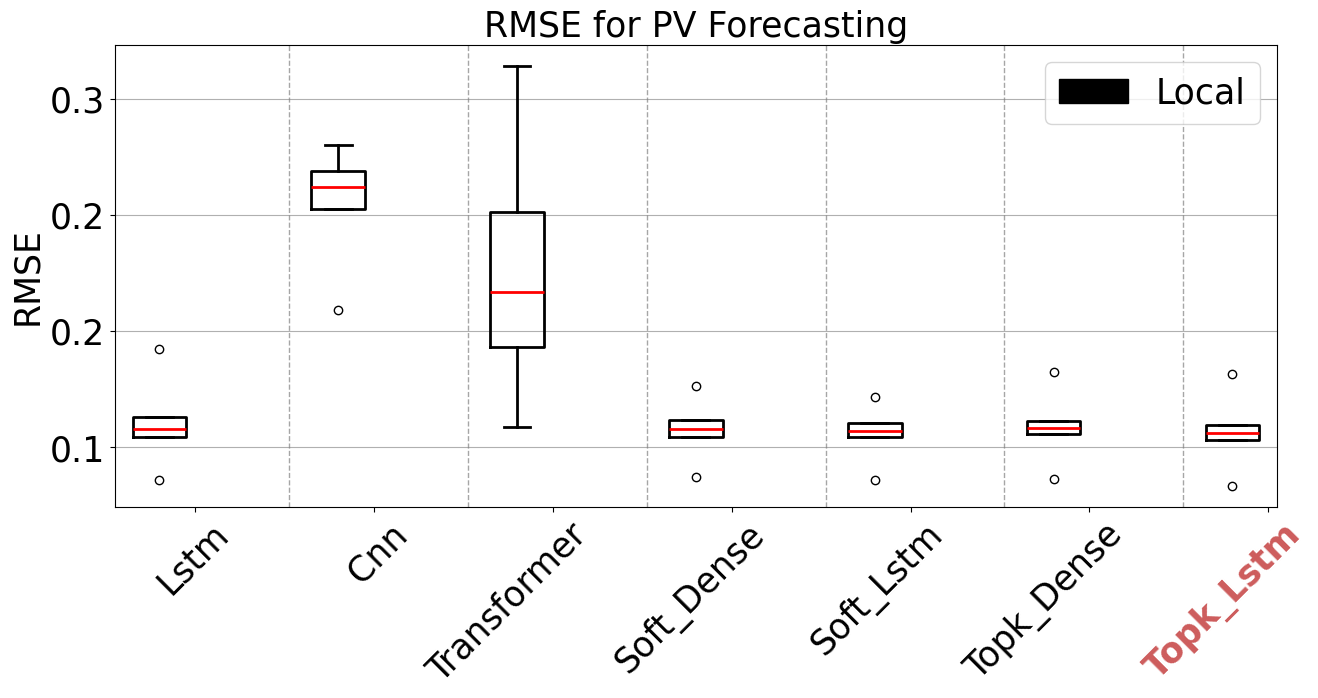

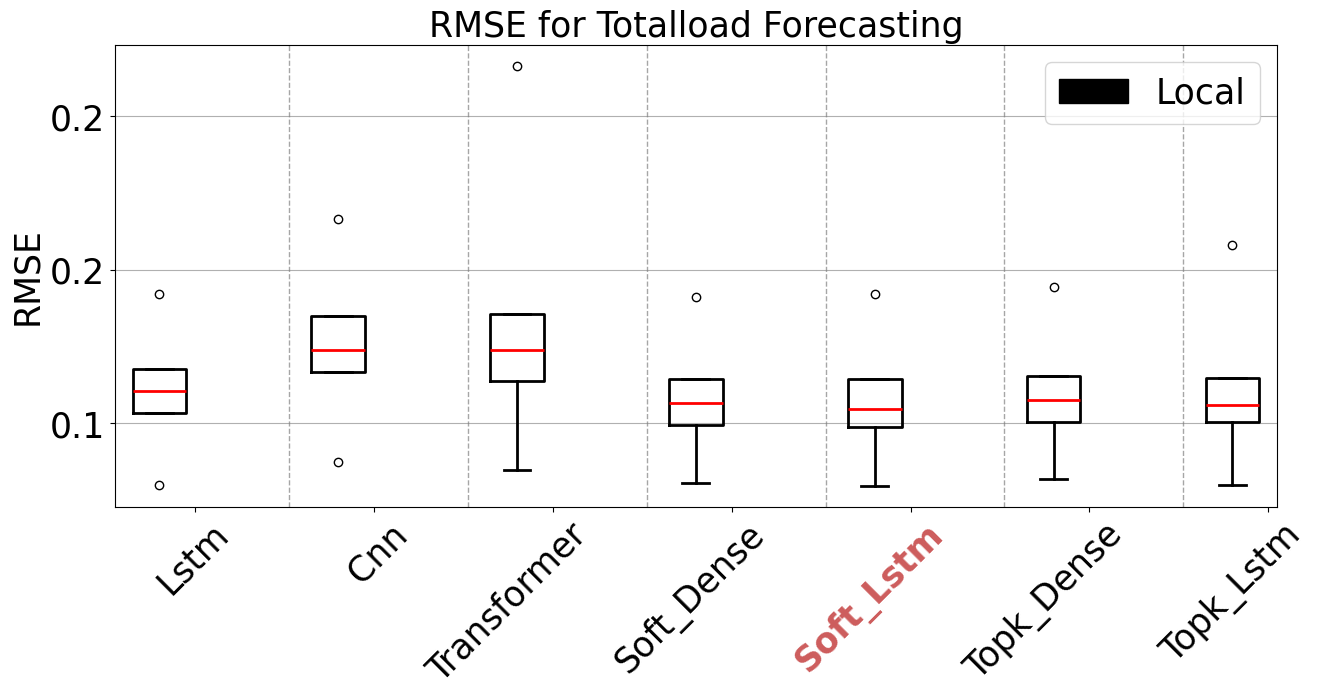

In [11]:
def plot_rmse_boxplot(df_ll, title, figsize=(15, 6)):
    """
    Function to plot a boxplot for RMSE values in the given DataFrames for LL and FL.
    """
    
    # Prepare data for boxplot
    boxplot_data_ll = df_ll.set_index('model')[['min', '25%', '50%', '75%', 'max']].T
    
    fontsize = 25
    # Plotting
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    
    # Plot Local Learning boxplots
    boxplot_data_ll.boxplot(positions=np.arange(len(boxplot_data_ll.columns))*2.0-0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black', 'linewidth': 2.0}, capprops={'color': 'black', 'linewidth': 2.0}, boxprops={'color': 'black', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

    plt.title(title, fontsize=fontsize)
    plt.ylabel('RMSE', fontsize=fontsize)
    #plt.ylim(0.050, 0.400)
    ax.tick_params(axis='y', labelsize=fontsize)
    
    x_ticks = np.arange(len(boxplot_data_ll.columns))*2.0
    x_labels = boxplot_data_ll.columns
    # Find the label with the lowest median
    lowest_median_label = x_labels[np.argmin(boxplot_data_ll.loc['50%'])]
    for i, label in enumerate(x_labels):
        if label == lowest_median_label:
            ax.get_xticklabels()[i].set_color("indianred")
            ax.get_xticklabels()[i].set_weight("bold")
    
    # Define the offset value (adjust this as needed)
    offset = 0.4  # You can change this value to control the offset
    # Offset the x-label text to the left
    for label in ax.get_xticklabels():
        transform = label.get_transform() + ScaledTranslation(offset, 0, plt.gcf().dpi_scale_trans)
        label.set_transform(transform)

    plt.xticks(x_ticks, x_labels, rotation=45, ha='right', fontsize=fontsize)
    # Add horizontal lines as separation between labels
    for i in range(1, len(x_ticks)):
        plt.axvline(x=x_ticks[i] - 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    
    plt.gca().xaxis.grid(False)
    black_patch = mpatches.Patch(color='black', label='Local')
    plt.legend(handles=[black_patch], fontsize=fontsize)
    plt.show()

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case
for use_case in use_cases: 
    df_ll = combined_average_metrics[(combined_average_metrics['data'] == use_case) & (combined_average_metrics['learning'] == 'LL')]
    title = get_plot_title_new(use_case)
    plot_rmse_boxplot(df_ll, title)

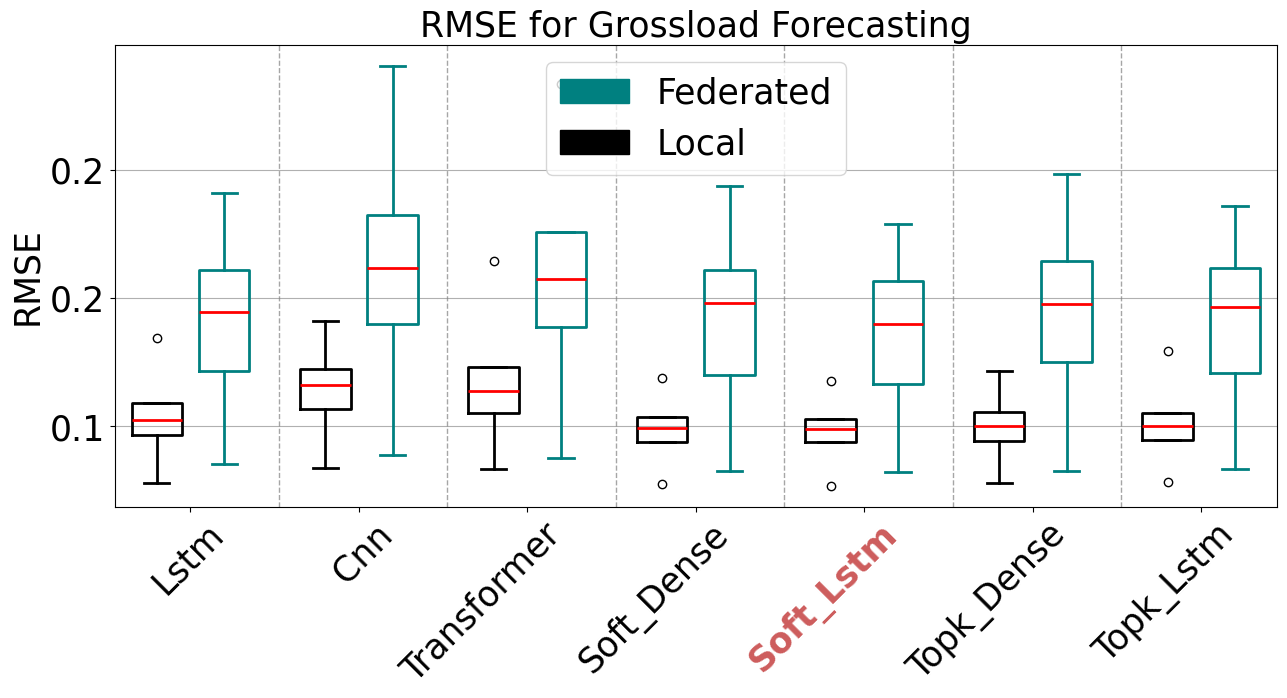

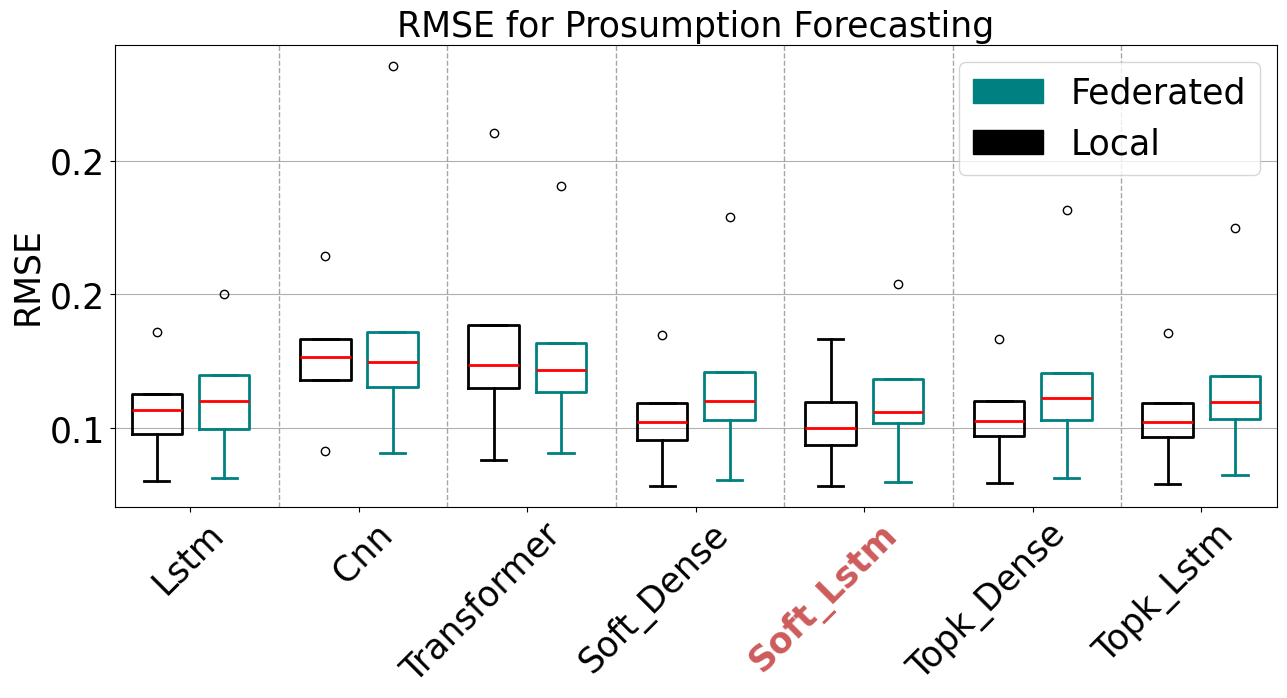

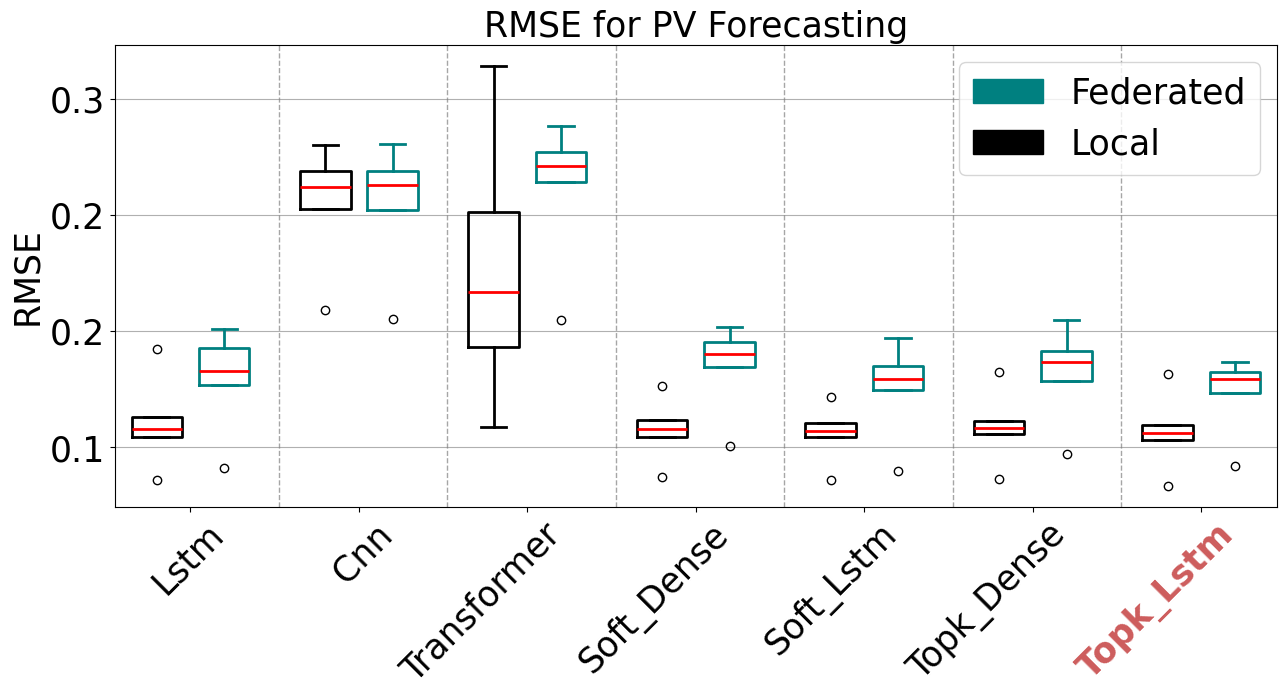

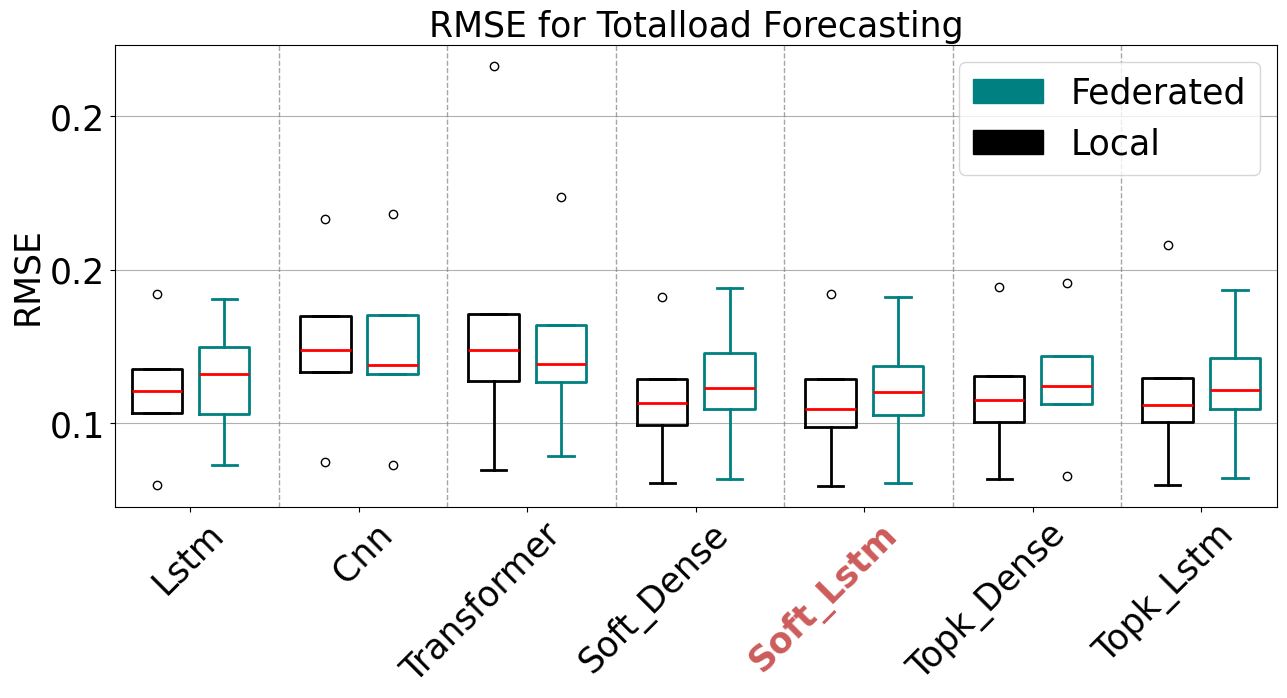

In [12]:
# With Federated Learning
def plot_rmse_boxplot(df_ll, df_fl, title, figsize=(15, 6)):
    """
    Function to plot a boxplot for RMSE values in the given DataFrames for LL and FL.
    """
    
    # Prepare data for boxplot
    boxplot_data_ll = df_ll.set_index('model')[['min', '25%', '50%', '75%', 'max']].T
    boxplot_data_fl = df_fl.set_index('model')[['min', '25%', '50%', '75%', 'max']].T


    fontsize = 25
    # Plotting
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    
    # Plot Local Learning boxplots
    boxplot_data_ll.boxplot(positions=np.arange(len(boxplot_data_ll.columns))*2.0-0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'black', 'linewidth': 2.0}, capprops={'color': 'black', 'linewidth': 2.0}, boxprops={'color': 'black', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

    # Plot Federated Learning boxplots in green
    boxplot_data_fl.boxplot(positions=np.arange(len(boxplot_data_fl.columns))*2.0+0.4, notch=False, meanline=True, showmeans=False, showcaps=True, showbox=True, whiskerprops={'color': 'teal', 'linewidth': 2.0}, capprops={'color': 'teal', 'linewidth': 2.0}, boxprops={'color': 'teal', 'linewidth': 2.0}, medianprops={'color': 'red', 'linewidth': 2.0}, widths=0.6)

    plt.title(title, fontsize=fontsize)
    plt.ylabel('RMSE', fontsize=fontsize)
    #plt.ylim(0.050, 0.400)
    ax.tick_params(axis='y', labelsize=fontsize)
    
    x_ticks = np.arange(len(boxplot_data_ll.columns))*2.0
    x_labels = boxplot_data_ll.columns
    # Find the label with the lowest median
    lowest_median_label = x_labels[np.argmin(boxplot_data_ll.loc['50%'])]
    for i, label in enumerate(x_labels):
        if label == lowest_median_label:
            ax.get_xticklabels()[i].set_color("indianred")
            ax.get_xticklabels()[i].set_weight("bold")
    
    # Define the offset value (adjust this as needed)
    offset = 0.4  # You can change this value to control the offset
    # Offset the x-label text to the left
    for label in ax.get_xticklabels():
        transform = label.get_transform() + ScaledTranslation(offset, 0, plt.gcf().dpi_scale_trans)
        label.set_transform(transform)

    plt.xticks(x_ticks, x_labels, rotation=45, ha='right', fontsize=fontsize)
    # Add horizontal lines as separation between labels
    for i in range(1, len(x_ticks)):
        plt.axvline(x=x_ticks[i] - 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    
    plt.gca().xaxis.grid(False)
    teal_patch = mpatches.Patch(color='teal', label='Federated')
    black_patch = mpatches.Patch(color='black', label='Local')
    plt.legend(handles=[teal_patch, black_patch], fontsize=fontsize)
    plt.show()

# Use cases
use_cases = ['Grossload', 'Prosumption', 'PV', 'Totalload']

# Plotting boxplots for each use case
for use_case in use_cases: 
    df_ll = combined_average_metrics[(combined_average_metrics['data'] == use_case) & (combined_average_metrics['learning'] == 'LL')]
    df_fl = combined_average_metrics[(combined_average_metrics['data'] == use_case) & (combined_average_metrics['learning'] == 'FL')]
    title = get_plot_title_new(use_case)
    plot_rmse_boxplot(df_ll, df_fl, title)

# Plot forecasts

In [20]:
import sys  
sys.path.append("../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *

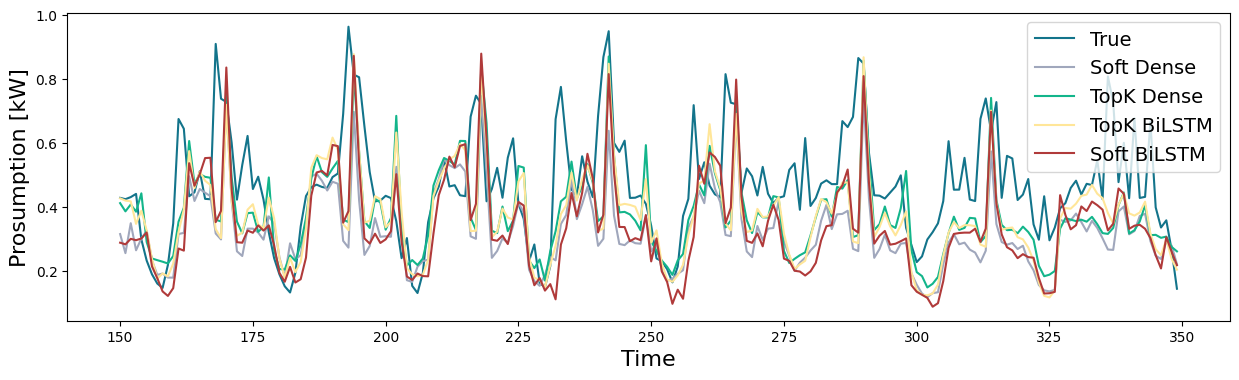

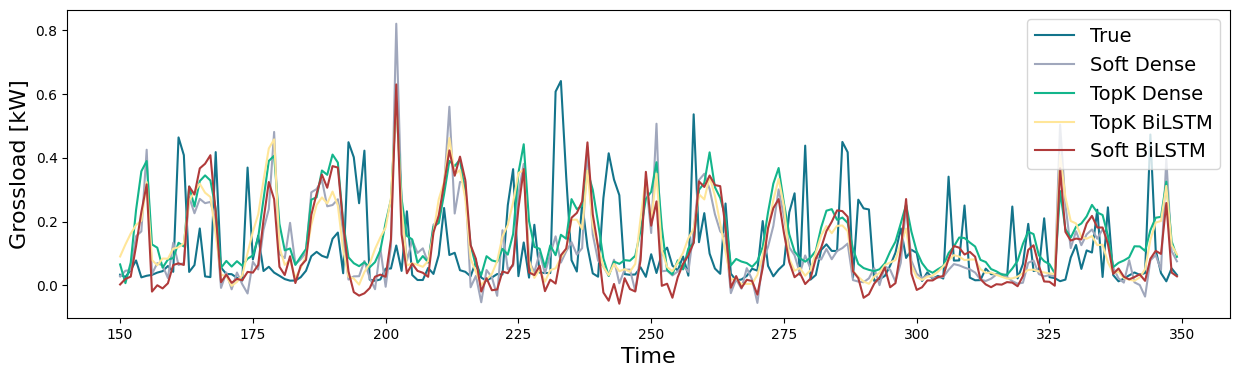

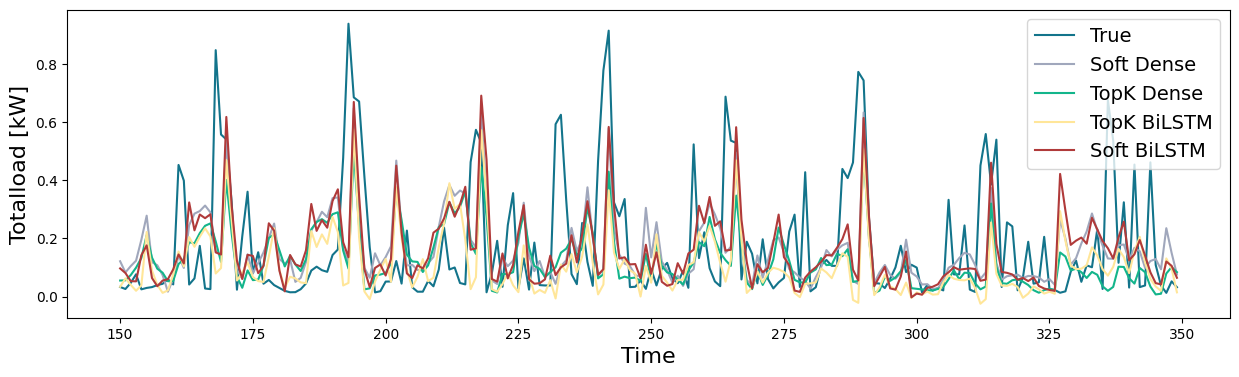

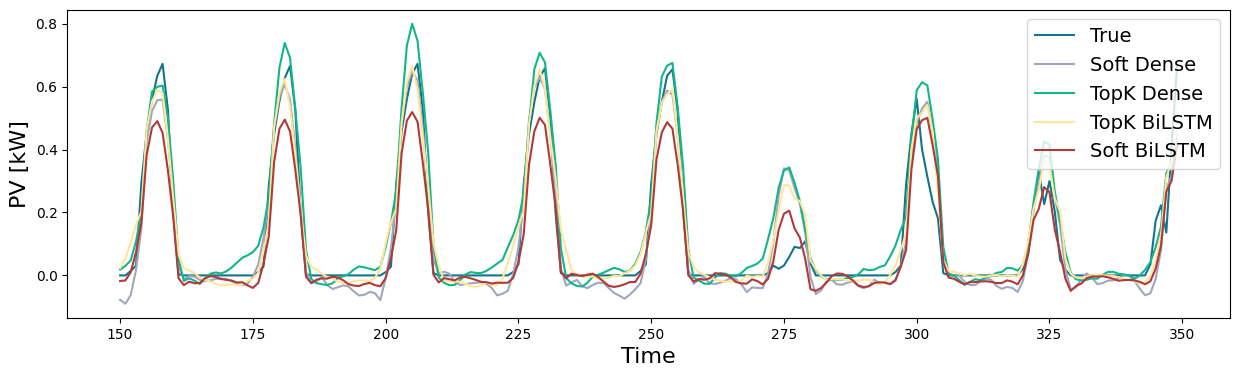

In [23]:
forecast_types = ['Prosumption', "Grossload", "Totalload", "PV"]
scaling_factors = {
    'Prosumption': 1.5,
    'Grossload': 1.0,
    'Totalload': 1.1,
    'PV': 0.8
}

for forecast_type in forecast_types:
    cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.getcwd())))
    stream_predictions = load_csv(cwd+ f'/data_streams/Locallearning/results/Predictions_DS_LL_{forecast_type}_Forecasting.csv')
    cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
    df = pd.read_csv(cwd+f'/data/3final_data/Final_{forecast_type}_dataset.csv', index_col='Date')
    df.index = pd.to_datetime(df.index)
    df.fillna(0, inplace=True)

    # Filter data for a specific period
    start_date = df.index.min() + pd.DateOffset(years=1)
    end_date = df.index.max()
    df = df[(df.index >= start_date) & (df.index < end_date)]

    df = min_max_scaling(df)
    df.reset_index(inplace=True, drop=True)

    # Plot prediction results
    start = 150
    stop = start + 200
    offset = -25
    scale_factor = scaling_factors[forecast_type]

    # Create a new x-axis scale for the stream_predictions
    stream_x_axis = range(start, stop)

    fig = plt.figure(figsize=(15, 4))
    plt.plot(df['User1'][start:stop], label='True', color='#13748B')
    plt.plot(stream_x_axis, stream_predictions["soft_dense"][start+offset:stop+offset] * scale_factor, label='Soft Dense', color='#A0A7BC')
    plt.plot(stream_x_axis, stream_predictions["topk_dense"][start+offset:stop+offset] * scale_factor, label='TopK Dense', color='#13B58B')
    plt.plot(stream_x_axis, stream_predictions["topk_bilstm"][start+offset:stop+offset] * scale_factor, label='TopK BiLSTM', color='#FFE699')
    plt.plot(stream_x_axis, stream_predictions["soft_bilstm"][start+offset:stop+offset] * scale_factor, label='Soft BiLSTM', color='#B03A3A')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel(f'{forecast_type} [kW]', fontsize=16)
    plt.legend(fontsize=14)
    #plt.title(f'{forecast_type} Forecast with Data Streams', fontsize=18)
    plt.savefig(f'Figure8_{forecast_type}.svg', format='svg', bbox_inches='tight')
    #plt.show()